#**Problem Statement**

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know the following things about the prospective properties:
* Which variables are significant in predicting the price of a house, and

* How well those variables describe the price of a house.
* Also, determine the optimal value of lambda for ridge and lasso regression.



#**Business Goal**

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

##**Step 1: Understand the Dataset**

In [446]:
#importing the required 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [447]:
data=pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [448]:
data.shape

(1460, 81)

In [449]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We have 38 Numerical columns and 43 categorical columns

In [450]:
data.describe(percentiles=[0.15,0.35,0.55,0.75,0.95])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
15%,219.850000,20.000000,50.000000,6120.000000,5.000000,5.000000,1936.000000,1955.000000,0.000000,0.000000,0.000000,121.850000,701.700000,804.000000,0.000000,0.000000,988.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1953.000000,1.000000,272.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2006.000000,115000.000000
35%,511.650000,20.000000,60.000000,8450.000000,5.000000,5.000000,1961.000000,1976.000000,0.000000,56.650000,0.000000,320.650000,864.000000,959.650000,0.000000,0.000000,1262.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,6.000000,0.000000,1968.000000,2.000000,412.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,141000.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
55%,803.450000,60.000000,70.000000,9794.500000,6.000000,5.000000,1977.000000,1996.000000,0.000000,450.000000,0.000000,544.000000,1040.000000,1132.450000,0.000000,0.000000,1509.450000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,7.000000,1.000000,1988.000000,2.000000,490.000000,63.450000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,172500.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
95%,1387.050000,160.000000,107.000000,17401.1500

It looks like we have outliers in the dataset.

Let's check for missing values

In [451]:
data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

###**Cleaning the Dataset**

In [452]:
#Check the missing values in percent of the dataset and store in a new dataframe
missing=pd.DataFrame(data.isnull().sum()/len(data)*100).reset_index()

Dropping columns which have more than 30% missing data

In [453]:


#col names with missing % >30
col=missing[missing[0] >30]
#col names with missing % <30
impute_col=missing[(missing[0]<30) & (missing[0]>0)]

#dropping columns
data=data.drop(col['index'],axis=1)

In [454]:
#Let's check the new dataset
data.shape

(1460, 76)

In [455]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

For Columns with less than 30 percent missing values, we will replace the nulls with the most occuring values for categorical variables and with median for numerical variables

In [456]:
impute_col

,index,0
3,LotFrontage,17.739726
25,MasVnrType,0.547945
26,MasVnrArea,0.547945
30,BsmtQual,2.534247
31,BsmtCond,2.534247
32,BsmtExposure,2.602740
33,BsmtFinType1,2.534247
35,BsmtFinType2,2.602740
42,Electrical,0.068493
58,GarageType,5.547945


The variables MasVnrType, BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1 BsmtFinType2,GarageType,GarageFinish,GarageQual,GarageCond have NAs which have a meaning as per the data/business understanding.
So we will impute NAs for the null values

In [457]:
impute_col=impute_col.drop([3,26])   #dropping numerical variables and treat them seperately

In [458]:
#for above mentioned variables, we will impute with NA to ensure they are imputed as per business understanding
na_cols=['MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','GarageCond']

data[na_cols]=data[na_cols].apply(lambda x:x.fillna('NA')) 

#drop the columns from the impute col field
impute_col = impute_col[~impute_col['index'].isin(na_cols)]

#Imputing the remaining categorical columns with the max occuring value
data[impute_col['index']]=data[impute_col['index']].apply(lambda x:x.fillna(x.value_counts().index[0])) 



In [459]:
#Imputing numerical columns with the median value of column
data['LotFrontage']=data['LotFrontage'].fillna(data['LotFrontage'].median())
data['MasVnrArea']=data['MasVnrArea'].fillna(data['LotFrontage'].median())


In [460]:
#Dropping the ID column since it does not add any information
data=data.drop(['Id'],axis=1)

Again checking missing values after the impute. 

In [461]:
data.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 75, dtype: int64

Looks like the missing values are cleared. Let's proceed with the data preparation

All the columns have been imputed. There are no nulls. We can proceed ahead with the data preparation

###**Visualizing the dataset features with the target variable**


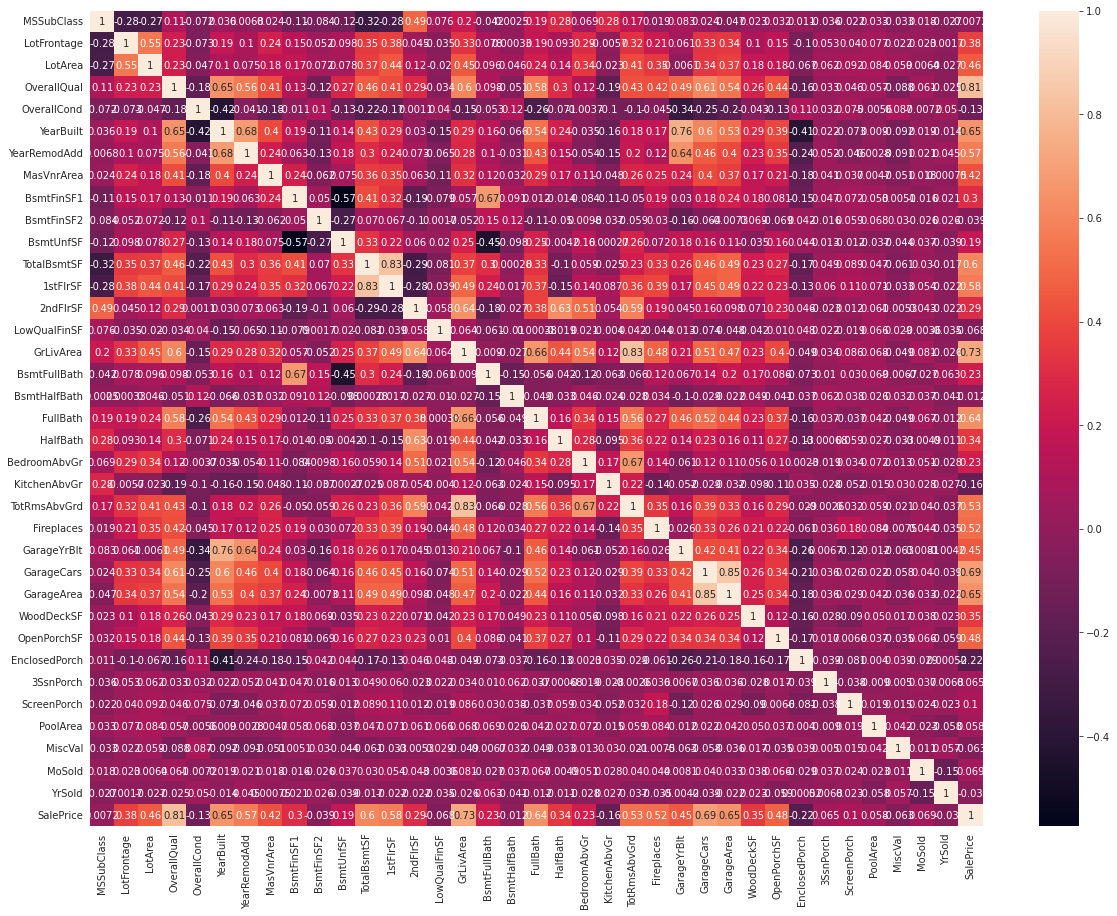

In [462]:
# Plotting heatmap to find the correlations

plt.figure(figsize=(20,15))  # setting figure size
sns.heatmap(data.corr(method='spearman'),annot=True)    # plotting heatmap
plt.show()

<Figure size 1080x2880 with 0 Axes>

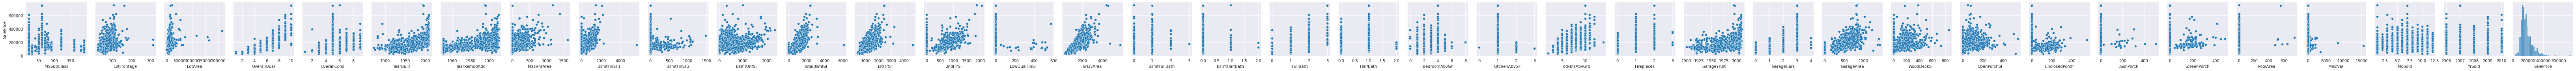

In [463]:
#Creating a pair plot for the categorical variables
plt.figure(figsize=(15,40)) 
sns.pairplot(data,y_vars='SalePrice')  #seeing the relationship between target variable and the other variables
plt.show()

From the initial pairplots, we can clearly see  non-linear relationships between the predictor categorical variables and the target variable

Let's explore the relationship between categorical variables and the target variable

###**Visualizing the dataset with the target variable**

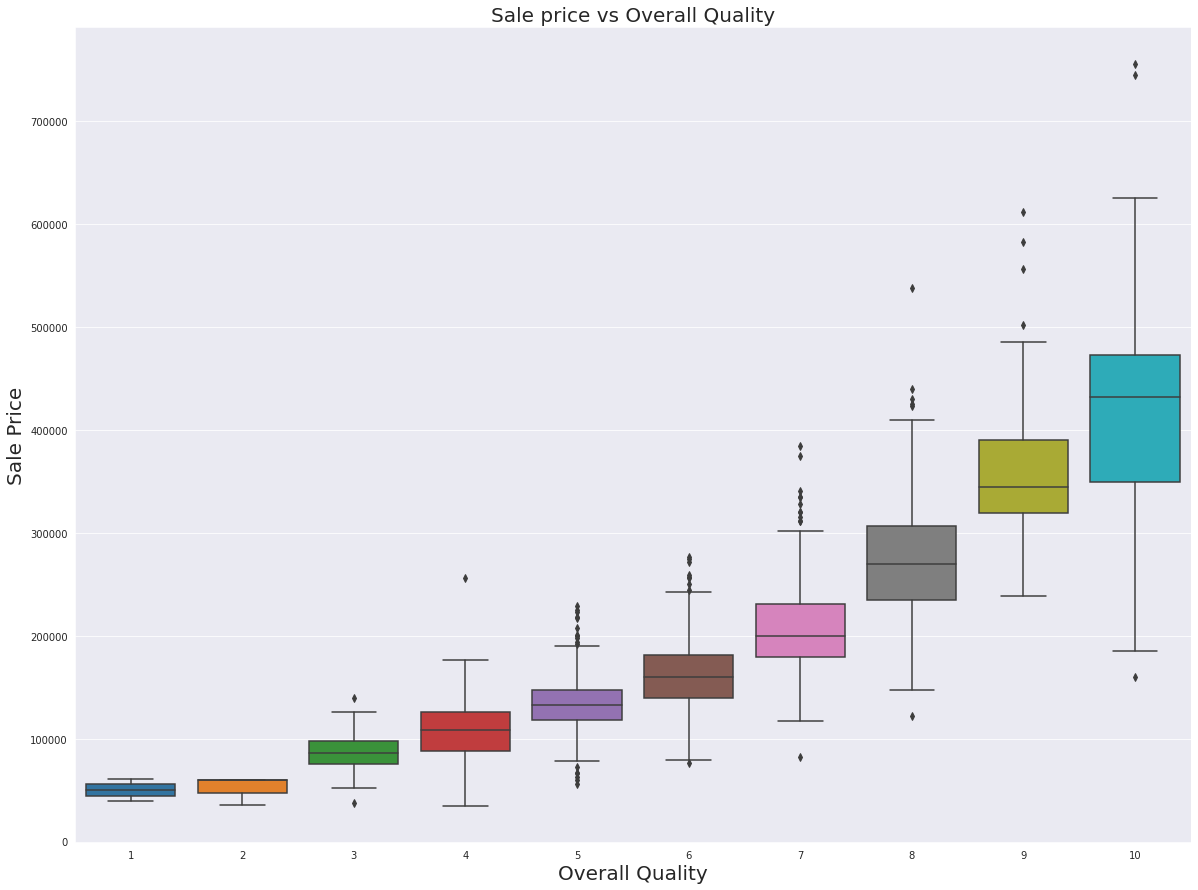

In [464]:
plt.figure(figsize=(20,15))                               # Setting the figure size
sns.boxplot(x='OverallQual',y='SalePrice',data=data)  # Creating boxplot to understand the distribution
plt.title('Sale price vs Overall Quality',fontsize=20)    # Setting the title
plt.xlabel('Overall Quality',fontsize=20)                 # Setting the x-label
plt.ylabel('Sale Price',fontsize=20)                      # Setting the x-label
plt.show()

Few points concluded from above boxplot -

* For Quality value 1, sale price is very less with other quality values
* For Quality value 10, sale price is the highest than the others
* For Quality value 10, we have some outliers as well
* Also we see that the sale price increase gradually (not linear) with the progression of quality value.

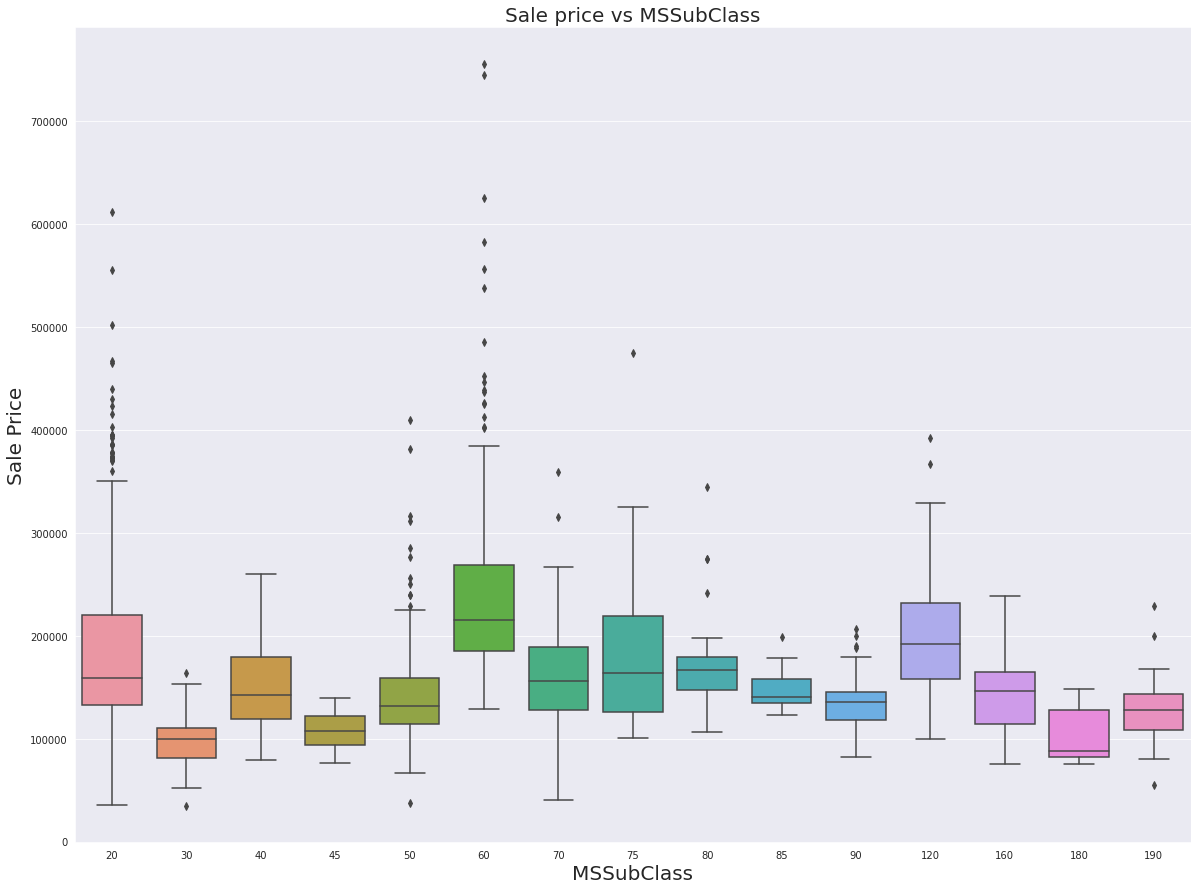

In [465]:
plt.figure(figsize=(20,15))                               # Setting the figure size
sns.boxplot(x='MSSubClass',y='SalePrice',data=data)  # Creating boxplot to understand the distribution
plt.title('Sale price vs MSSubClass',fontsize=20)    # Setting the title
plt.xlabel('MSSubClass',fontsize=20)                 # Setting the x-label
plt.ylabel('Sale Price',fontsize=20)                      # Setting the x-label
plt.show()

From the above graph, we can conclude that 
* The MS Subclass in the range 50 - 75 (more than 1 story) have higher pricing. 
* 60 - 2 Story but newer than 1946 have the most outliers

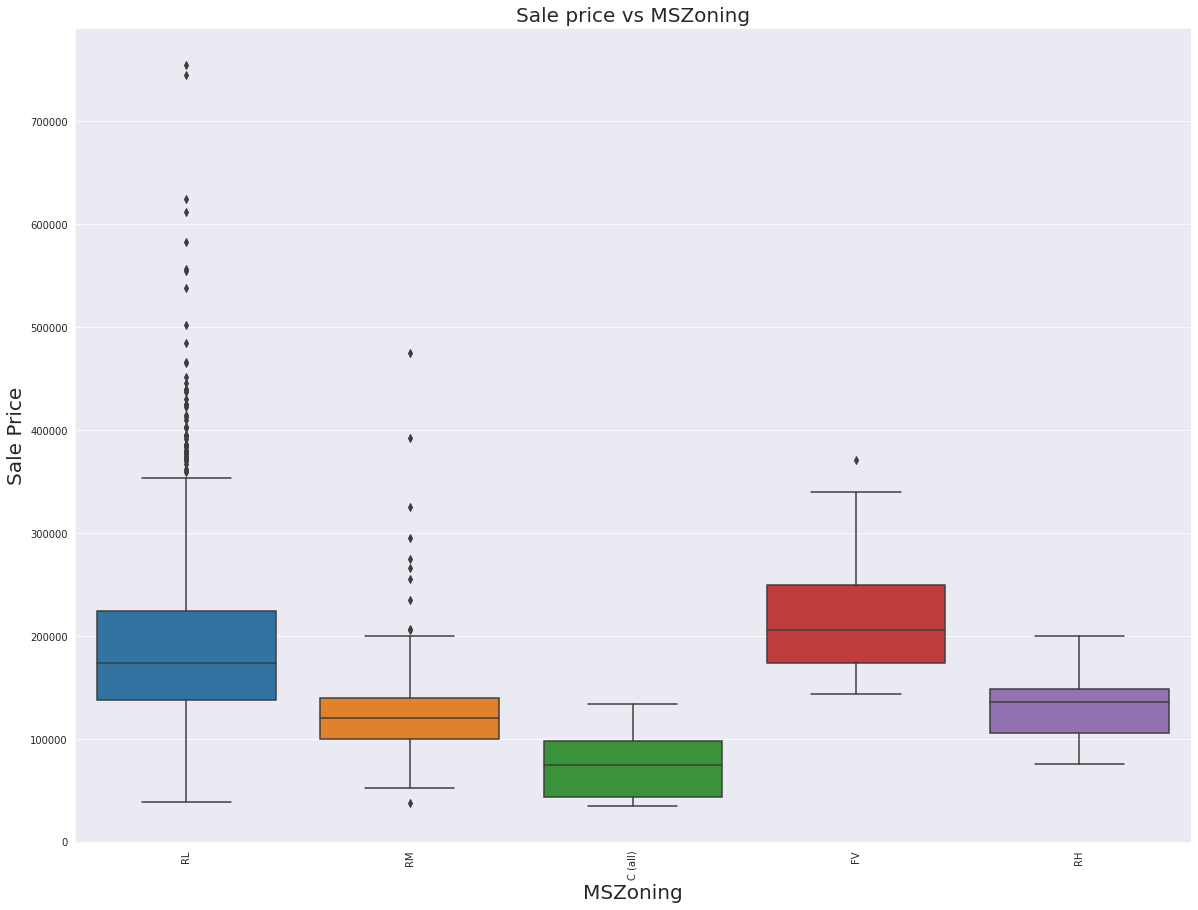

In [466]:
plt.figure(figsize=(20,15))                              # Setting the figure size
sns.boxplot(x='MSZoning',y='SalePrice',data=data)       # Creating boxplot to understand the distribution
plt.title('Sale price vs MSZoning',fontsize=20)         # Setting the title
plt.xlabel('MSZoning',fontsize=20)                      # Setting the x-label
plt.ylabel('Sale Price',fontsize=20)                     # Setting the x-label
plt.xticks(rotation=90)                                  # Setting the rotaion on x - axis
plt.show()


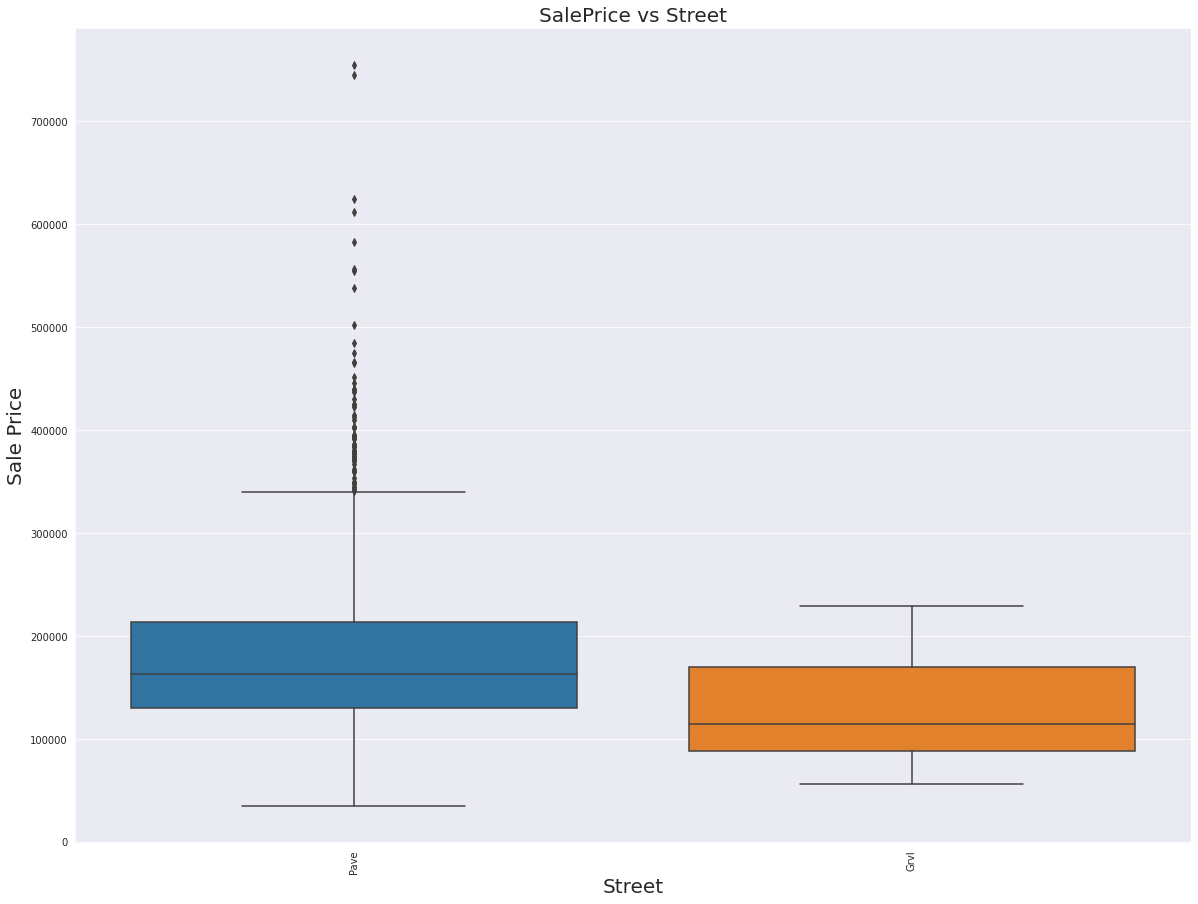

In [467]:
plt.figure(figsize=(20,15))                              # Setting the figure size
sns.boxplot(x='Street',y='SalePrice',data=data)   # Creating boxplot to understand the distribution
plt.title('SalePrice vs Street',fontsize=20)         # Setting the title
plt.xlabel('Street',fontsize=20)                      # Setting the x-label
plt.ylabel('Sale Price',fontsize=20)                     # Setting the x-label
plt.xticks(rotation=90)                                  # Setting the rotaion on x - axis
plt.show()

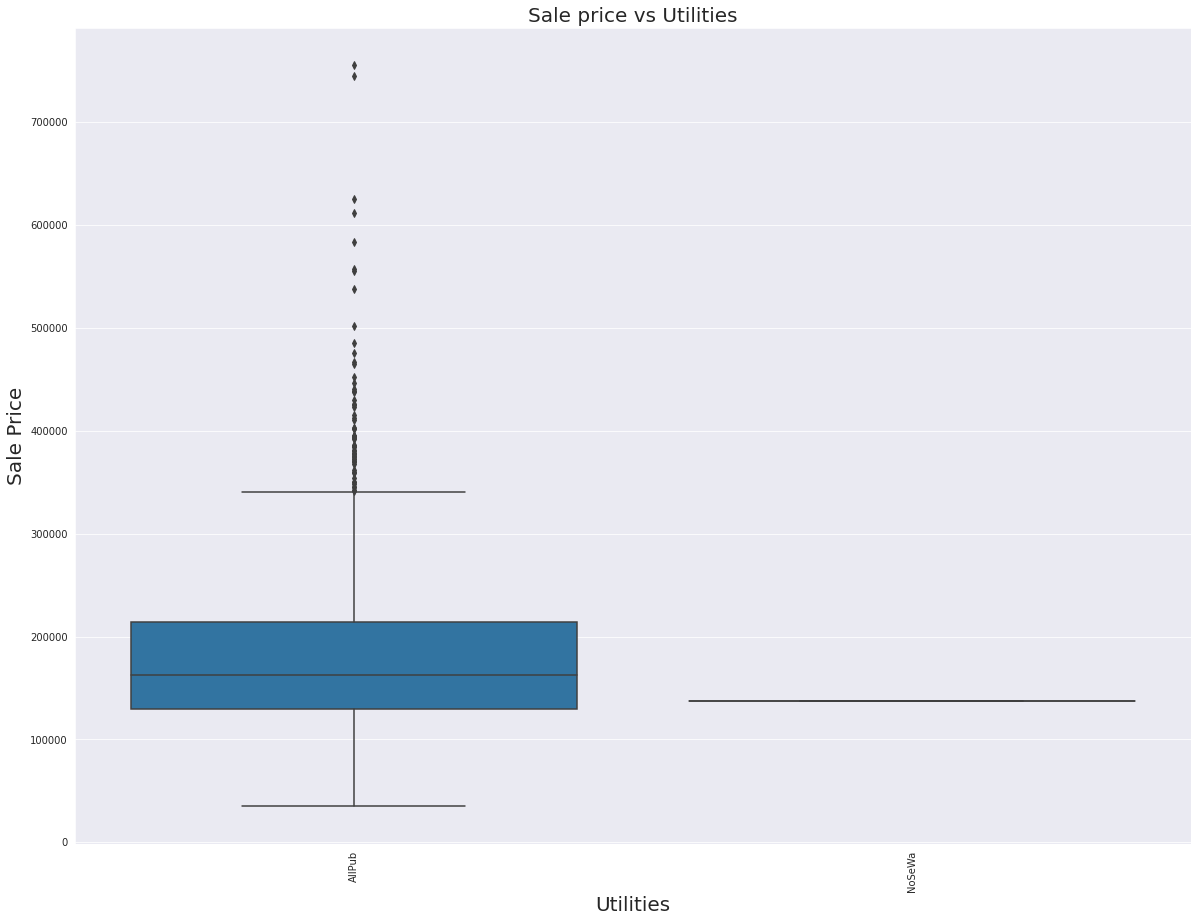

In [468]:
plt.figure(figsize=(20,15))                              # Setting the figure size
sns.boxplot(x='Utilities',y='SalePrice',data=data)   # Creating boxplot to understand the distribution
plt.title('Sale price vs Utilities',fontsize=20)         # Setting the title
plt.xlabel('Utilities',fontsize=20)                      # Setting the x-label
plt.ylabel('Sale Price',fontsize=20)                     # Setting the x-label
plt.xticks(rotation=90)                                  # Setting the rotaion on x - axis
plt.show()

From the aboce plot of MSZoning, Street and Utility, we can say that
* Properties that fall under Zones which are FV - Floating Village Residential or RL- Residential Low Density have a higher value
* RL- Residential Low Density has the most outliers
* Property having paved streets are values more than gravel streets
* Property having all public utilities (E,G,W,& S) are valued

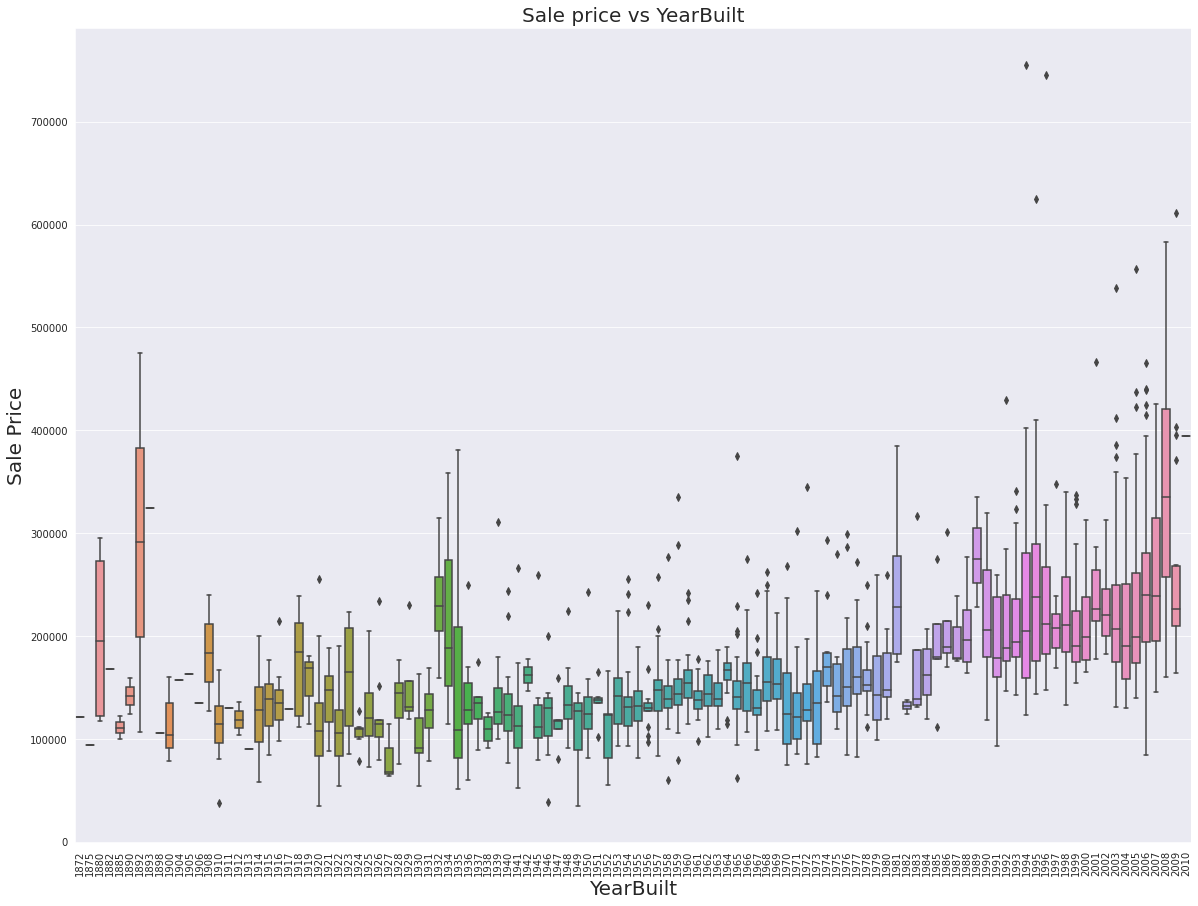

In [469]:
plt.figure(figsize=(20,15))                              # Setting the figure size
sns.boxplot(x='YearBuilt',y='SalePrice',data=data)   # Creating boxplot to understand the distribution
plt.title('Sale price vs YearBuilt',fontsize=20)         # Setting the title
plt.xlabel('YearBuilt',fontsize=20)                      # Setting the x-label
plt.ylabel('Sale Price',fontsize=20)                     # Setting the x-label
plt.xticks(rotation=90)                                  # Setting the rotaion on x - axis
plt.show()

Few points concluded from above boxplot -

* Properties built before 2000 are showing a decline meaning older homes have lesser value
* Properties built after 2000 have high value (Upper trend)
* There are few outliers for properties having very high age.

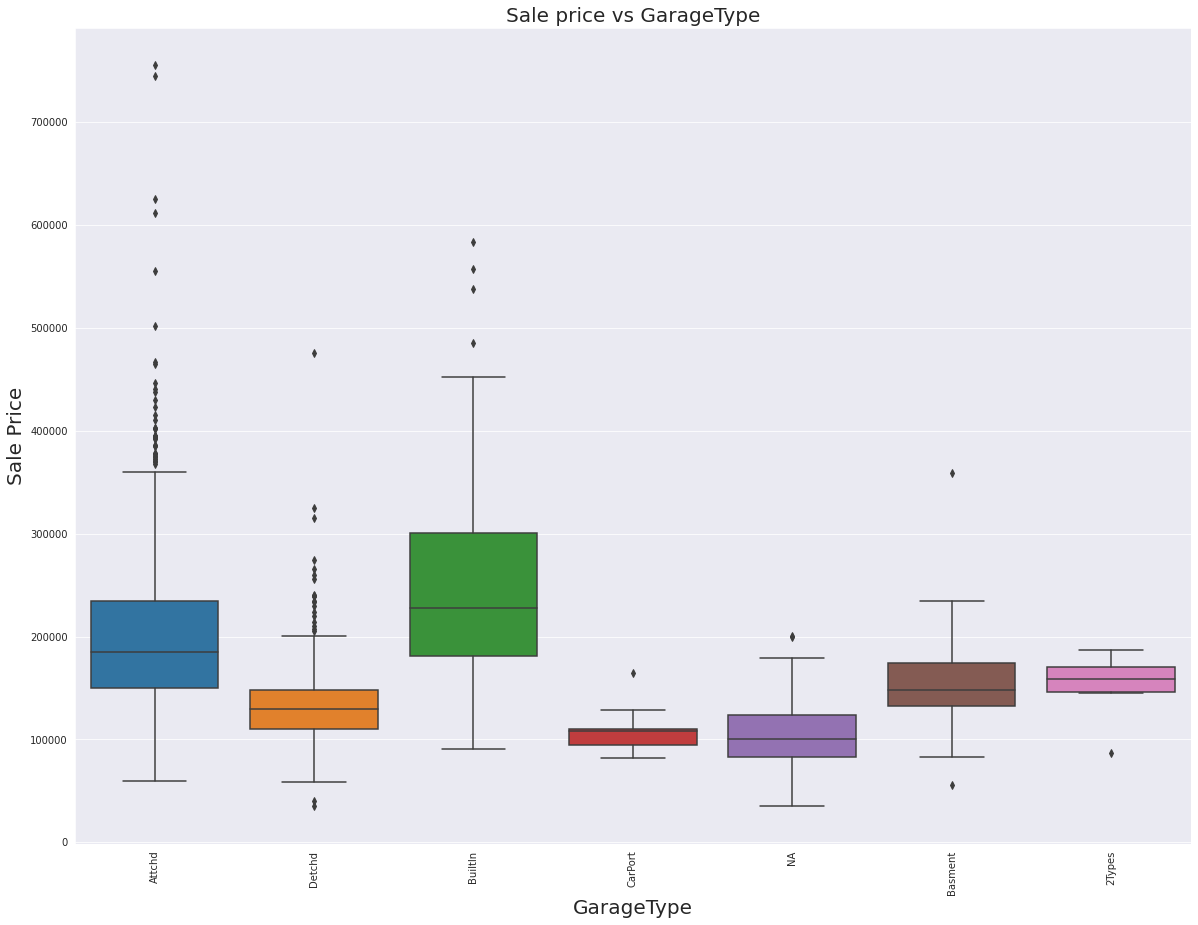

In [470]:
plt.figure(figsize=(20,15))                              # Setting the figure size
sns.boxplot(x='GarageType',y='SalePrice',data=data)   # Creating boxplot to understand the distribution
plt.title('Sale price vs GarageType',fontsize=20)         # Setting the title
plt.xlabel('GarageType',fontsize=20)                      # Setting the x-label
plt.ylabel('Sale Price',fontsize=20)                     # Setting the x-label
plt.xticks(rotation=90)                                  # Setting the rotaion on x - axis
plt.show()

* Attached and Builtin Garages are preferred over other garage types
* Attached Garages have the most outliers

##**Step 2: Data Preparation**

In [471]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


###**Encoding Numerical variables**

In [472]:
#Converting the Yes/No type columns in 1/0 (Encoding)

encode_cols=['CentralAir','PavedDrive']

for i in encode_cols:
  data[i]=data[i].replace('Y',1)
  data[i]=data[i].replace('N',0)


In [473]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,1,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,1,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,1,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,1,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,1,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


Dummy coding is used for categorical data, e.g., car brands or hair colors. Dates and years aren't. They are interval scaled. Interval scaled data should be translated into a single predictor that counts the number of days, years (or seconds) since an arbitrary origin

In [474]:
#Let's subtract the Built year and the max year of sold year to create a new variable called Age of the property.
max_yr=data['YrSold'].max()
data['Property_age']=max_yr-data['YearBuilt']

In [475]:
#Let's subtract the garage built year and the  max year of sold year to create a new variable called Garage_sold to aggregate the garage age.
data['Garage_age']=max_yr-data['GarageYrBlt']

In [476]:
#For remodelling i.e. addition, we need to capture if there are were any modifications, if Yes, then capture the age of the remodelling else 0

data['Remod_age'] = np.where(data['YearBuilt']!= data['YearRemodAdd'], max_yr-data['YearRemodAdd'], 0)

In [477]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Property_age,Garage_age,Remod_age
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,1,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,7,7.0,0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,1,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,34,34.0,0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,1,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,9,9.0,8
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,1,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,95,12.0,40
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,1,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,10,10.0,0


In [478]:
#Dropping the original year columns
data=data.drop(['YearBuilt','GarageYrBlt','YrSold','YearRemodAdd'],axis=1)

In [479]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Property_age,Garage_age,Remod_age
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,RFn,2,548,TA,TA,1,0,61,0,0,0,0,0,2,WD,Normal,208500,7,7.0,0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,RFn,2,460,TA,TA,1,298,0,0,0,0,0,0,5,WD,Normal,181500,34,34.0,0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,RFn,2,608,TA,TA,1,0,42,0,0,0,0,0,9,WD,Normal,223500,9,9.0,8
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,Unf,3,642,TA,TA,1,0,35,272,0,0,0,0,2,WD,Abnorml,140000,95,12.0,40
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,RFn,3,836,TA,TA,1,192,84,0,0,0,0,0,12,WD,Normal,250000,10,10.0,0


In [480]:
#Checking the numerical distribution again
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,Property_age,Garage_age,Remod_age
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,103.495205,443.639726,46.549315,567.240411,1057.429452,0.934932,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890,38.732192,30.023973,11.123288
std,42.300571,22.027677,9981.264932,1.382997,1.112799,180.587278,456.098091,161.319273,441.866955,438.705324,0.246731,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883,30.202904,24.749688,19.306762
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,1.000000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000,10.000000,7.000000,0.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1.000000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000,37.000000,25.500000,0.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1.000000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000,56.000000,48.000000,13.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,1.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000,138.000000,110.000000,60.000000


###**Dummy Variable Encoding**

In [481]:
#Creating a list of categorical variables

cat_cols=data.loc[:,data.dtypes=='object']

In [482]:
dummies=pd.get_dummies(cat_cols,drop_first=True)
dummies

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_1,PavedDrive_P,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1456,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1457,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1458,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [483]:
#merge the dummies with the original dataset
data=pd.concat([data,dummies],axis=1)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_1,PavedDrive_P,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,1,SBrkr,856,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,1,SBrkr,1262,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,1,SBrkr,920,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,1,SBrkr,961,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,1,SBrkr,1145,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [484]:
#delete the original columns
data=data.drop(cat_cols,axis=1)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,Property_age,Garage_age,Remod_age,MSZoning_FV,MSZoning_RH,MSZoning_RL,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_1,PavedDrive_P,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,196.0,706,0,150,856,1,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,208500,7,7.0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,0.0,978,0,284,1262,1,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,181500,34,34.0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,162.0,486,0,434,920,1,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,223500,9,9.0,8,0,0,1,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,0.0,216,0,540,756,1,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,140000,95,12.0,40,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,350.0,655,0,490,1145,1,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,250000,10,10.0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [485]:
#Splitting the data into X - 'Predictor variable' and y-'Target variable'
y=data.pop('SalePrice')
X=data.copy()

###**Scaling**

In [486]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

#selecting columns for scaling
scale_col=X.select_dtypes(['float64','int64']).columns

X[scale_col]=scaler.fit_transform(X[scale_col])

In [487]:
#Splitting the data into training and testing set
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=100)

In [488]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1021, 241), (439, 241), (1021,), (439,))

##**Step 3: Model Building**

###**Ridge Regression**

In [489]:
#importing the required libraries
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [490]:
#creating a ridge object
ridge=Ridge()


In [491]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,Property_age,Garage_age,Remod_age,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_1,PavedDrive_P,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
318,0.073375,0.914450,-0.061820,0.651479,-0.517200,0.844783,1.191731,-0.288653,-0.469172,0.660283,0.263813,0.541779,2.124318,-0.120242,2.152171,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,1.527656,0.600495,1.650307,0.856307,1.961401,0.201405,1.997536,-0.116339,-0.270208,-0.068692,-0.087688,-0.85911,-0.719786,-0.526408,-0.576332,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
239,-0.163109,-0.811244,-0.177977,-0.071836,-1.416142,-0.573300,-0.766852,-0.288653,0.166984,-0.735209,0.263813,-0.943516,0.783740,-0.120242,-0.054186,-0.819964,-0.241061,-1.026041,1.227585,0.163779,-0.211454,0.296763,0.600495,-1.026858,-1.183635,-0.752176,1.409256,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.85911,0.870009,1.252001,2.532453,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
986,-0.163109,-0.493353,-0.521839,-0.071836,2.179628,-0.573300,-0.973018,-0.288653,-0.186184,-1.305262,0.263813,-0.418229,0.657703,-0.120242,0.227558,-0.819964,-0.241061,-1.026041,-0.761621,-1.062465,-0.211454,-0.934130,-0.951226,-1.026858,-1.019878,2.392381,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.11911,2.029235,1.211583,-0.213640,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1416,3.147673,-0.447940,0.082500,-1.518467,0.381743,-0.573300,-0.973018,-0.288653,0.474875,-0.639440,0.263813,0.215738,1.597253,-0.120242,1.474464,-0.819964,-0.241061,0.789741,-0.761621,1.390023,4.328579,2.758549,-0.951226,0.311725,0.407146,-0.752176,-0.704483,1.506523,-0.116339,-0.270208,-0.068692,-0.087688,-0.85911,2.857254,0.362797,2.532453,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
390,-0.163109,-0.902070,-0.211652,-0.795151,2.179628,-0.573300,-0.444442,2.135943,-0.765742,-0.447901,0.263813,-0.521734,0.135221,-0.120242,-0.282626,1.107810,-0.241061,-1.026041,-0.761621,1.390023,-0.211454,0.296763,-0.951226,-1.026858,-0.416317,-0.752176,1.258275,1.473789,-0.116339,-0.270208,-0.068692,-0.087688,-0.85911,2.360443,0.079868,2.532453,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [492]:
#Initiating Ridge regression with a range of alpha values
params={'alpha':[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100, 200,400]}

#Define folds for Kcross validation
folds=KFold(n_splits=5,shuffle=True,random_state=100)

#Grid search cross validation for ridge regression

ridge_cv=GridSearchCV(estimator=ridge,param_grid=params,scoring='neg_mean_absolute_error',cv=folds,return_train_score=True,verbose=1)

#fitting the model
ridge_cv.fit(X_train,y_train)

# Creating new dataframe for cv results

ridge_cv_results=pd.DataFrame(ridge_cv.cv_results_)
ridge_cv_results.head()

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    3.8s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.013355,0.001395,0.002392,0.000033,0.001,{'alpha': 0.001},-21157.436731,-19111.694760,-21153.483759,-24171.960084,-23815.934787,-21882.102024,1882.250773,32,-11879.327504,-12599.893420,-11435.280339,-11372.307503,-11713.222337,-11800.006221,440.362124
1,0.012156,0.000197,0.002236,0.000040,0.01,{'alpha': 0.01},-20606.844254,-18903.665346,-21473.784520,-23526.929111,-22982.866688,-21498.817984,1664.133187,31,-11929.334315,-12598.055087,-11526.922526,-11433.004135,-11877.545695,-11872.972352,410.430280
2,0.017835,0.004688,0.002767,0.000940,0.1,{'alpha': 0.1},-19858.449508,-18269.849130,-23200.798933,-22480.122493,-21005.576356,-20962.959284,1776.756081,30,-13220.284683,-12629.354367,-13058.431484,-12587.631538,-13387.244850,-12976.589385,318.302938
3,0.012708,0.001481,0.002242,0.000013,0.2,{'alpha': 0.2},-19760.415185,-17956.049939,-23164.198370,-22124.603342,-20594.146976,-20719.882762,1817.860176,29,-13853.403543,-12701.150391,-13660.957865,-13076.332019,-13987.028823,-13455.774528,489.055082
4,0.020590,0.004610,0.003754,0.001223,0.3,{'alpha': 0.3},-19728.371668,-17827.450858,-22871.781689,-21866.716087,-20387.832671,-20536.430594,1745.688174,28,-14197.891595,-12789.032227,-13968.745330,-13315.663569,-14283.010627,-13710.868670,572.190111


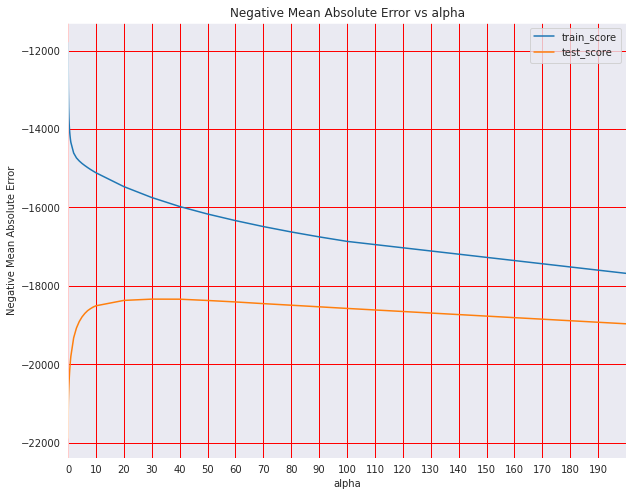

In [493]:
# Setting graph style

sns.set_style('darkgrid')

# Setting figure size

plt.figure(figsize=(10,8))

# Plotting the Ridge with cv rsults with train score and test score

plt.plot(ridge_cv_results['param_alpha'],ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'],ridge_cv_results['mean_test_score'])

# Setting x- label and y- label

plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

# Setting the title

plt.title('Negative Mean Absolute Error vs alpha')

# Setting the legend

plt.legend(['train_score','test_score'],loc='upper right')
plt.xlim(0, 200)
plt.xticks(np.arange(0, 200, 10))
plt.grid(color='r', linestyle='-', linewidth=1)
plt.show()

**From the above graph, we can say that optimal alpha we found is 30, hence we will fit the train set with alpha value 30.**

In [494]:
alpha=30                  # setting the alpha value as 30

ridge=Ridge(alpha=alpha)   # Creating object with alpha 25 value
ridge.fit(X_train,y_train) # Fitting the ridge
ridge.coef_                # Getting the coefficients

array([-6.78942169e+03, -2.50166865e+03,  3.61036341e+03,  1.66359047e+04,
        6.06781993e+03,  4.72988705e+03,  3.33683370e+02,  1.02194550e+03,
        1.36827523e+03,  2.10083491e+03,  2.68964964e+02,  6.12439847e+03,
        1.23786522e+04, -1.04596039e+03,  1.46920674e+04,  5.31568068e+03,
        8.16364687e+02,  3.80274717e+03,  1.15599538e+03, -1.90789675e+03,
       -3.30136167e+03,  2.81679254e+03,  3.08313757e+03,  9.74333894e+03,
        2.11510417e+02,  2.13030816e+03, -6.62902705e+02,  6.21376911e+02,
        1.34514540e+03,  1.40575339e+03, -5.41123366e+02, -1.16147961e+02,
       -4.73455343e+02, -6.03772535e+03, -6.12587979e+02,  2.01550420e+02,
        2.90076899e+03,  1.25970272e+03,  3.66116993e+03, -3.25523439e+03,
        2.75921146e+03,  1.24128350e+03, -6.26503088e+03,  3.04673366e+02,
        5.43213993e+03,  3.72514140e+03,  8.58196400e+03, -1.40226609e+03,
        6.25841777e+03, -4.78346202e+03, -8.98319394e+02, -1.21747925e+03,
        4.96016931e+03, -

In [495]:
print(ridge.score(X_train,y_train))   # Printing the r2 value for train set
print(ridge.score(X_test,y_test))     # Printing the r2 value for test set


0.8782225147848025
0.8684969984560852


In [496]:
#Let's see the features of the model

features_ridge=pd.DataFrame(zip(X_train.columns,ridge.coef_))

features_ridge=features.rename(columns={0: 'Variable', 1: 'Coeff/Score'})
features_ridge.sort_values(by='Coeff/Score',key=abs,ascending=False,inplace=True)

In [497]:
features_ridge.head(20)

,Variable,Coeff/Score
12,2ndFlrSF,28849.296616
194,Electrical_FuseF,-27142.868316
157,Foundation_PConc,-26998.981873
195,Electrical_FuseP,-26102.272389
59,Neighborhood_Crawfor,-25154.367678
159,Foundation_Stone,-21330.680843
63,Neighborhood_MeadowV,-21258.769461
193,HeatingQC_TA,-19102.581597
11,1stFlrSF,17866.954022
45,LandContour_Low,17550.010314


**Ridge regression model is having good r2 score of 87.8% (train) and 86.8% (test) for alpha 30 hence this is the final model.**

###**Lasso Regression**

In [498]:
#importing the lasso model
from sklearn.linear_model import Lasso

#creating an object of the model
lasso=Lasso()

lasso_model=GridSearchCV(estimator=lasso,param_grid=params,scoring='neg_mean_absolute_error',cv=folds,return_train_score=True,verbose=1)

#fitting the lasso model
lasso_cv=lasso_model.fit(X_train,y_train)

# Creating new dataframe for cv results

lasso_cv_results=pd.DataFrame(lasso_cv.cv_results_)
lasso_cv_results.head()

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   32.6s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.275605,0.031017,0.002789,0.000525,0.001,{'alpha': 0.001},-21231.101404,-18859.221963,-21244.542896,-24215.710733,-23962.956618,-21902.706723,1987.040513,31,-11885.800612,-12607.566409,-11447.013063,-11382.503003,-11704.296862,-11805.435990,439.872734
1,0.256985,0.011704,0.003317,0.001788,0.01,{'alpha': 0.01},-21226.573228,-18927.440006,-21237.978688,-24207.567004,-23959.216738,-21911.755133,1964.303280,32,-11885.775600,-12607.661560,-11447.014897,-11382.392763,-11704.275983,-11805.424160,439.928384
2,0.238006,0.014433,0.002490,0.000136,0.1,{'alpha': 0.1},-21182.373575,-18899.480614,-21174.287814,-24165.780862,-23922.926521,-21868.969877,1962.954036,30,-11885.974212,-12608.852875,-11447.341399,-11381.803883,-11704.631490,-11805.720772,440.413927
3,0.241091,0.014456,0.002551,0.000242,0.2,{'alpha': 0.2},-21138.571017,-18861.199062,-21136.706308,-24135.738532,-23881.888685,-21830.820721,1964.646695,29,-11886.415760,-12610.445938,-11447.862705,-11381.345598,-11706.055665,-11806.425133,440.949342
4,0.237660,0.016443,0.002425,0.000014,0.3,{'alpha': 0.3},-21095.184355,-18848.561902,-21123.508383,-24107.176966,-23840.929583,-21803.072238,1957.232984,28,-11887.368666,-12611.518151,-11448.438528,-11380.784816,-11707.507574,-11807.123547,441.323681


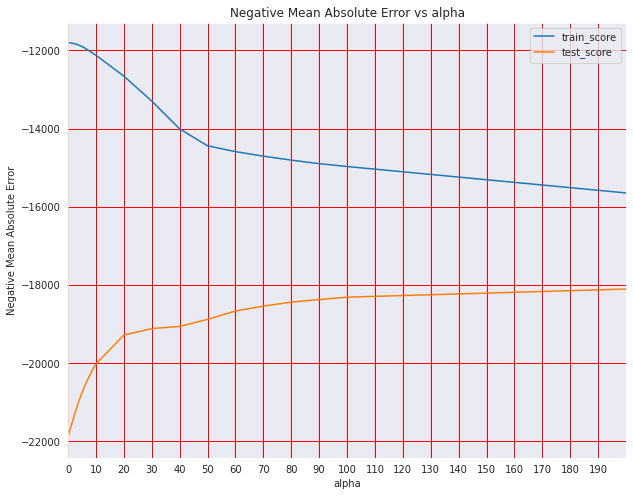

In [499]:
# Setting graph style

sns.set_style('darkgrid')

# Setting figure size

plt.figure(figsize=(10,8))

# Plotting the Ridge with cv rsults with train score and test score

plt.plot(lasso_cv_results['param_alpha'],lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'],lasso_cv_results['mean_test_score'])

# Setting x- label and y- label

plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

# Setting the title

plt.title('Negative Mean Absolute Error vs alpha')

# Setting the legend

plt.legend(['train_score','test_score'],loc='upper right')
plt.xlim(0, 200)
plt.xticks(np.arange(0, 200, 10))
plt.grid(color='r', linestyle='-', linewidth=1)
plt.show()

**From the above graph, we can say that optimal alpha we found is 60, hence we will fit the train set with alpha value 60.**

In [500]:
alpha=60                             # setting the alpha value as 60
lasso1=Lasso(alpha=alpha,max_iter=10e5)  # Creating object with alpha 60 value
lasso1.fit(X_train,y_train)              # Fitting the Lasso
lasso1.coef_

array([-5.71593615e+03, -2.16338682e+03,  4.21496609e+03,  1.30878191e+04,
        6.03882231e+03,  3.46697752e+03, -0.00000000e+00,  1.18078537e+03,
        7.50227105e+02,  1.13027895e+03,  4.68327271e+02,  0.00000000e+00,
        7.25118682e+03, -2.07918160e+03,  2.75145381e+04,  4.74763840e+03,
        7.72574985e+02,  3.45539657e+03, -0.00000000e+00, -1.81796591e+03,
       -3.64483310e+03,  3.27273013e+02,  1.37239360e+03,  1.02220029e+04,
       -2.63167054e+03,  1.23960379e+03,  1.97775137e+02,  5.38599203e+02,
        1.11517559e+03,  1.19161005e+03, -4.69112267e+02, -6.01011512e+01,
       -3.56289999e+02, -6.37111053e+03, -3.41200746e+02,  0.00000000e+00,
        0.00000000e+00,  2.03682664e+03,  5.31457733e+03, -0.00000000e+00,
        8.88216047e+03,  0.00000000e+00, -2.14693782e+04,  8.71735106e+02,
        9.73689286e+03,  9.27593552e+03,  1.19984682e+04, -0.00000000e+00,
        9.02750917e+03, -8.46047026e+03, -0.00000000e+00, -5.31124455e+02,
        1.95918286e+03,  

The lasso automatically reduces co-efficients to zero and penalizing the features which don't add value

In [501]:
print(lasso1.score(X_train,y_train))   # Printing the r2 value for train set
print(lasso1.score(X_test,y_test))     # Printing the r2 value for test set
print(np.sum(lasso1.coef_!=0))         # Number of coefficients not equal to 0

0.9095304479827313
0.85381827078799
136


##**Step 4: Model Evaluation**

####**Predictions - Train**

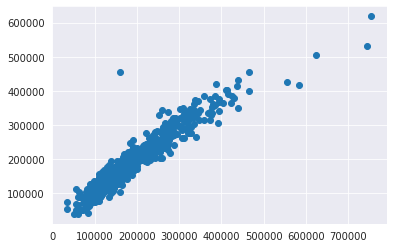

In [502]:
#Prediction on train set
y_train_pred=lasso1.predict(X_train)

res=y_train-y_train_pred

plt.scatter(y_train,y_train_pred)
plt.show()


Residual Plot (Train Data)

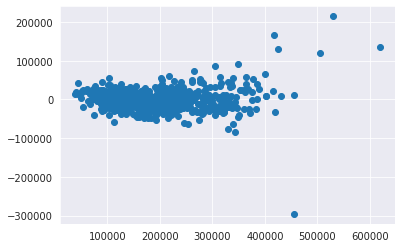

In [503]:
plt.scatter(y_train_pred,res)
plt.show()


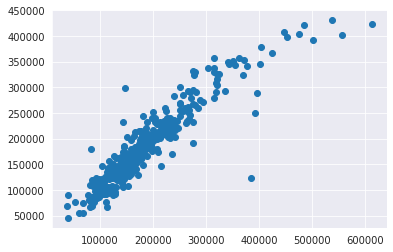

In [504]:
#Prediction on test set
y_test_pred=lasso1.predict(X_test)

res2=y_test-y_test_pred

plt.scatter(y_test,y_test_pred)
plt.show()

Residual Plot - (Test Data)

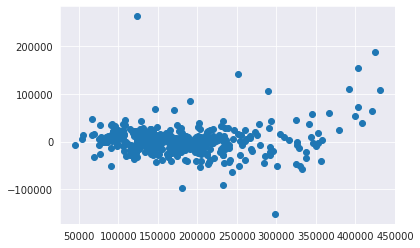

In [505]:
plt.scatter(y_test_pred,res2)
plt.show()


**The model has a good accuracy of 90% on trainingg set and 85.4 on testing set. This is the final model for lasso.**

In [506]:
#Let's see the features of the model

features=pd.DataFrame(zip(X_train.columns,lasso1.coef_))

features=features.rename(columns={0: 'Variable', 1: 'Coeff/Score'})
features.sort_values(by='Coeff/Score',key=abs,ascending=False,inplace=True)

In [507]:
features

,Variable,Coeff/Score
89,Condition2_PosN,-264359.965073
115,RoofMatl_WdShngl,88507.068052
68,Neighborhood_NoRidge,41962.331786
109,RoofMatl_CompShg,29785.075191
69,Neighborhood_NridgHt,28624.817105
...,...,...
71,Neighborhood_SWISU,0.000000
80,Condition1_PosA,0.000000
140,Exterior2nd_Stone,-0.000000
138,Exterior2nd_Other,0.000000


In [508]:
#Top 10 Features
features.head(30)

,Variable,Coeff/Score
89,Condition2_PosN,-264359.965073
115,RoofMatl_WdShngl,88507.068052
68,Neighborhood_NoRidge,41962.331786
109,RoofMatl_CompShg,29785.075191
69,Neighborhood_NridgHt,28624.817105
199,KitchenQual_Gd,-28033.413104
14,GrLivArea,27514.538063
200,KitchenQual_TA,-27253.054945
162,BsmtQual_Gd,-26565.562084
59,Neighborhood_Crawfor,23697.257455


##**Conclusion**

From the modelling, we can conclude that the Lasso regression is better than ridge.

**Business Problem Answers:**

*  The Variables in the Top10 list explain the Pricing
    * Condition 2- Location of House
    * Roof Material
    * Neighbourhood
    * Kitchen Quality
    * Basement Quality
    * Lot Shape
    * Exterior Material
    * GrLivArea: Above grade (ground) living area square feet
    * Overall Quality
    * Land Contour

  * The Optimal Value for **Ridge Regression** is **30**
  * The optimal value for **Lasso Regression** is **60**

